In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_original = pd.read_csv('data/wallet_behavior.csv.gz')

print(f"Data shape: {df_original.shape}")
print(f"Memory usage: {df_original.memory_usage(deep=True).sum() / 1e6:.2f} MB")

Data shape: (1200000, 14)
Memory usage: 387.60 MB


In [3]:
df = df_original.copy()
df['total_tx_count'] = df['n_sent_tx'] + df['n_received_tx']
df['fan_out_ratio'] = df['n_unique_counterparties'] / df['total_tx_count']
df['tx_per_day'] = df['total_tx_count'] / (df['days_active_in_window'] + 1)
df['is_smart_contract_user'] = df['avg_gas_used_sent'] > 21000
df['log_total_sent_eth'] = np.log1p(df['total_sent_eth'])
df['log_n_token_sent'] = np.log1p(df['n_token_sent'])

print("New risk features engineered!")
df.head()

New risk features engineered!


,address,n_sent_tx,n_received_tx,total_sent_eth,total_received_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,first_tx_time,last_tx_time,days_active_in_window,n_token_sent,n_token_received,n_unique_tokens_moved,total_tx_count,fan_out_ratio,tx_per_day,is_smart_contract_user,log_total_sent_eth,log_n_token_sent
0,0x053cae897e0921049c2e80722d79131342bc91ec,8,26,17.665875,1.799945e+01,15,2.100000e+04,0.234971,2025-11-22 20:40:23 UTC,2025-12-09 21:56:11 UTC,17,12,9,19,34,0.441176,1.888889,False,2.926697,2.564949
1,0x89074ef1b6f23737076c234ccc41d428b6800426,4,0,6.561320,0.000000e+00,1,1.240741e+06,1.215176,2025-12-02 16:38:47 UTC,2025-12-09 19:54:23 UTC,7,0,16,13,4,0.250000,0.500000,True,2.023046,0.000000
2,0x62fb4d112ef7b06c3adc4bd0e605383879af2803,53,1,0.000651,2.402326e-03,3,6.211500e+04,0.558433,2025-11-14 18:58:11 UTC,2025-12-12 16:18:11 UTC,27,109,60,32,54,0.055556,1.928571,True,0.000651,4.700480
3,0x2c08cb703ca1126023a2dbc1afccb0a78d7250a5,6,8,2.064938,2.080000e-07,8,4.352533e+04,0.746667,2025-11-17 18:03:59 UTC,2025-11-22 08:53:47 UTC,4,19,6,14,14,0.571429,2.800000,True,1.120027,2.995732
4,0xbb9d0b030698816e025c224f8645e9657c85dc5f,16,3,0.098640,3.000000e-09,3,8.899856e+04,1.155044,2025-11-14 02:47:59 UTC,2025-12-07 04:53:59 UTC,23,84,32,22,19,0.157895,0.791667,True,0.094073,4.442651


In [4]:
# FIX LOYALTY (Continuous is better for clustering)
# cap it at 30 (window is 30 days)
df['days_active_capped'] = df['days_active_in_window'].clip(upper=30)

# CREATE "MULE SCORE" (The Mathematical Trick)
# A 'Mule' has In ≈ Out. So Flow Ratio ≈ 1.0.
# We want a score that is HIGH when ratio is 1.0, and LOW otherwise.
# Formula: 1 / (1 + abs(log(flow_ratio)))
# If ratio is 1.0, log is 0, score is 1.0 (High Risk).
# If ratio is 0.01 or 100, score drops near 0.
df['flow_ratio'] = df['total_received_eth'] / (df['total_sent_eth'] + 1e-6)
df['mule_score'] = 1 / (1 + np.abs(np.log1p(df['flow_ratio'] - 1)))

# SELECT & LOG-TRANSFORM FEATURES
# pick the features that define pillars: Volume, Complexity, Behavior
features_to_use = [
    'n_sent_tx',
    'n_received_tx',
    'total_sent_eth',
    'n_unique_counterparties',
    'avg_gas_used_sent',
    'avg_gas_price_gwei_sent',
    'n_token_sent',
    'days_active_capped',
    'fan_out_ratio',
    'mule_score'
]

X_raw = df[features_to_use].copy()
X_raw = X_raw.fillna(0)

# Apply Log Transform to skewed columns (Money, Counts, Gas)
# We leave 'fan_out_ratio' and 'mule_score' alone as they are already 0-1 ranges
skewed_cols = ['n_sent_tx', 'n_received_tx', 'total_sent_eth',
               'n_unique_counterparties', 'avg_gas_used_sent',
               'avg_gas_price_gwei_sent', 'n_token_sent', 'days_active_capped']

X_log = X_raw.copy()
for col in skewed_cols:
    X_log[col] = np.log1p(X_log[col])

print("Features Engineered & Log Transformed.")

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Features Engineered & Log Transformed.


In [5]:
X_log

,n_sent_tx,n_received_tx,total_sent_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,n_token_sent,days_active_capped,fan_out_ratio,mule_score
0,2.197225,3.295837,2.926697,2.772589,9.952325,0.211048,2.564949,2.890372,0.441176,0.981637
1,1.609438,0.000000,2.023046,0.693147,14.031220,0.795332,0.000000,2.079442,0.250000,0.000000
2,3.988984,0.693147,0.000651,1.386294,11.036759,0.443681,4.700480,3.332205,0.055556,0.433960
3,1.945910,2.197225,1.120027,2.197225,10.681121,0.557709,2.995732,1.609438,0.571429,0.058443
4,2.833213,1.386294,0.094073,1.386294,11.396387,0.767811,4.442651,3.178054,0.157895,0.054620
...,...,...,...,...,...,...,...,...,...,...
1199995,1.098612,0.693147,0.000000,1.098612,10.929215,1.386294,2.890372,0.000000,0.666667,0.094022
1199996,3.465736,0.000000,2.178698,2.302585,11.878988,0.107196,1.791759,2.708050,0.290323,0.000000
1199997,2.639057,0.693147,0.021196,2.484907,12.110997,0.717840,1.098612,3.332205,0.785714,0.426210
1199998,1.386294,0.000000,0.000000,0.693147,11.050128,0.675634,2.772589,3.218876,0.333333,0.000000


In [6]:
# ROBUST SCALING
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Scaled and Ready for Clustering.")

Data Scaled and Ready for Clustering.


In [7]:
X_scaled_df

,n_sent_tx,n_received_tx,total_sent_eth,n_unique_counterparties,avg_gas_used_sent,avg_gas_price_gwei_sent,n_token_sent,days_active_capped,fan_out_ratio,mule_score
0,3.709511,4.754888,270.082491,4.128534,-0.595699,-0.036035,2.700440,4.169925,-1.676471,1.817690
1,2.259851,0.000000,186.691276,-1.000000,2.483996,0.804249,-1.000000,3.000000,-2.250000,0.000000
2,8.128534,1.000000,0.059532,0.709511,0.223083,0.298525,5.781360,4.807355,-2.833333,0.803560
3,3.089694,3.169925,103.358429,2.709511,-0.045435,0.462514,3.321928,2.321928,-1.285714,0.108218
4,5.278053,2.000000,8.680810,0.709511,0.494613,0.764670,5.409391,4.584963,-2.526316,0.101139
...,...,...,...,...,...,...,...,...,...,...
1199995,1.000000,1.000000,-0.000512,0.000000,0.141884,1.654137,3.169925,0.000000,-1.000000,0.174099
1199996,6.838045,0.000000,201.055257,2.969362,0.858993,-0.185388,1.584963,3.906891,-2.129032,0.000000
1199997,4.799205,1.000000,1.955507,3.419023,1.034167,0.692804,0.584963,4.807355,-0.642857,0.789209
1199998,1.709511,0.000000,-0.000512,-1.000000,0.233177,0.632106,3.000000,4.643856,-2.000000,0.000000


Running Elbow Method on sample...


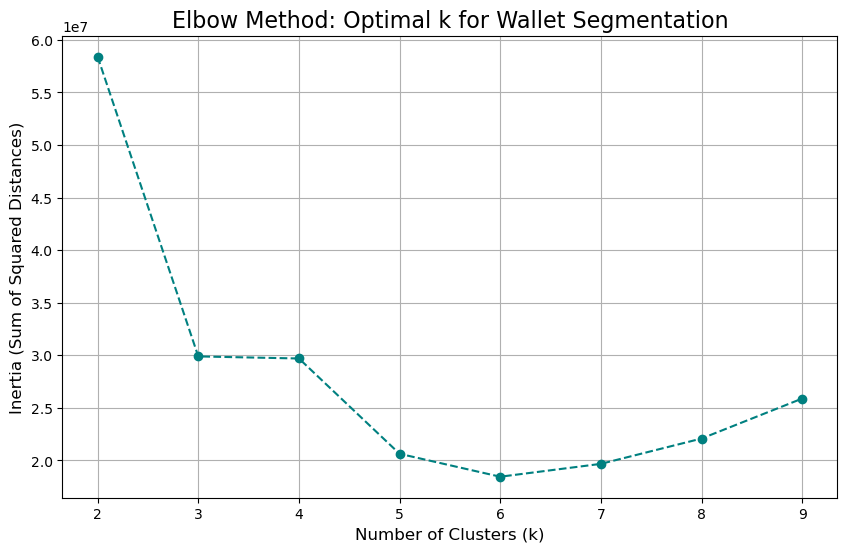

In [8]:
# 5. ELBOW METHOD (Using a Sample)
sample_size = 100000
X_sample = X_scaled_df.sample(n=sample_size, random_state=42)

inertia = []
K_range = range(2, 10) # Test 2 to 9 clusters

print("Running Elbow Method on sample...")
for k in K_range:
    # MiniBatchKMeans is faster for large datasets
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=10)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method: Optimal k for Wallet Segmentation', fontsize=16)
plt.grid(True)
plt.show()

In [12]:
# TRAIN & PREDICT

# 1. Initialize the Final Model
# Change n_clusters to 4, 5, or 6 based on your graph
k_best = 4 
kmeans_final = KMeans(n_clusters=k_best, random_state=42, n_init=10)

# 2. Fit on the scaled matrix (The Math)
print(f"Training KMeans with k={k_best}...")
kmeans_final.fit(X_scaled_df)

# 3. Assign labels back to the ORIGINAL DataFrame (The Context)
# This is where 'address' and 'total_sent_eth' meet the clusters
df['cluster_id'] = kmeans_final.labels_

print("Clustering Complete! 'cluster_id' column added to df.")

# --- STEP 7: INTERPRETATION (WHO ARE THEY?) ---

# We group by the NEW cluster ID and look at the OLD original columns
summary = df.groupby('cluster_id').agg({
    'address': 'count',                         # Size of the cluster
    'total_sent_eth': 'mean',                   # How rich are they?
    'n_sent_tx': 'mean',                        # How active?
    'avg_gas_price_gwei_sent': 'mean',          # Are they urgent (Bots)?
    'days_active_in_window': 'mean',            # Are they loyal?
    'fan_out_ratio': 'mean',                    # Are they spammers?
    'mule_score': 'mean',                       # Are they laundering money?
    'n_token_sent': 'mean'                      # Do they use DeFi?
}).round(4)

# Rename for clarity
summary = summary.rename(columns={'address': 'Wallet Count'})
print(summary)

Training KMeans with k=4...
Clustering Complete! 'cluster_id' column added to df.
            Wallet Count  total_sent_eth  n_sent_tx  avg_gas_price_gwei_sent  \
cluster_id                                                                     
0                1130039          0.0237     3.7252                   0.9258   
1                  17819         14.3436    21.2965                   1.3582   
2                   2988       2204.0988   542.1359                   1.7922   
3                  49154          1.7528    13.9422                   1.3665   

            days_active_in_window  fan_out_ratio  mule_score  n_token_sent  
cluster_id                                                                  
0                          2.6038         0.8462      0.2532        3.2682  
1                          9.0418         0.6067      0.6425       16.4036  
2                         12.1851         0.4943      0.6452      315.5154  
3                          7.8613         0.6617    

**Cluster 2: "The Whales & Institutions" (The VIPs)**
- Who they are: The top 0.2% (2,988 wallets).

- Behavior: They move massive amounts of money (~2,200 ETH avg) and are extremely active (~542 tx/month). They are heavily involved in DeFi (~315 token txs).

- Risk Signal: High Gas Price (1.79 Gwei). They pay extra for speed, which suggests algorithmic trading or institutional movement.

- Product Policy: "White Glove Service." Do not block them. Assign a dedicated Account Manager. If they trip a fraud alert, call them personally.

**Cluster 1: "DeFi Pros" (The High-Value Users)**
- Who they are: ~1.5% of users (17,819 wallets).

- Behavior: Significant wealth (~14 ETH moved). They are "Crypto Natives"—they engage with tokens frequently (16 token txs) and stay active (9 days/month).

- Risk Signal: Balanced Mule Score (0.64). They spend what they receive, which is normal for active traders.

- Product Policy: "Frictionless Experience." These are your best retail customers. Relax transaction limits for them, but monitor for Account Takeover (ATO).

**Cluster 3: "Active Retail" (The Middle Class)**
- Who they are: ~4% of users (49,154 wallets).

- Behavior: The standard user. They move modest amounts (~1.75 ETH) and have moderate activity (~14 tx).

- Risk Signal: Similar behavioral patterns to Pros, just less money.

- Product Policy: "Standard Monitoring." Apply standard daily limits. Use 2FA triggers if behavior suddenly spikes to "Whale" levels.

**Cluster 0: "The Long Tail" (Casuals & Airdrop Farmers)**
- Who they are: The massive 94% majority (1.13M wallets).

- Behavior: "Dust" users. They move almost nothing (~0.02 ETH) and barely interact (~2.6 days active).

- Risk Signal: Highest Fan-Out (0.85). This is the danger zone for Sybil Attacks (creating 10,000 fake accounts to farm rewards) or "Burner Wallets."

- Product Policy: "Strict Automation." No manual review (too expensive). Apply strict identity verification (KYC) before allowing them to increase limits.

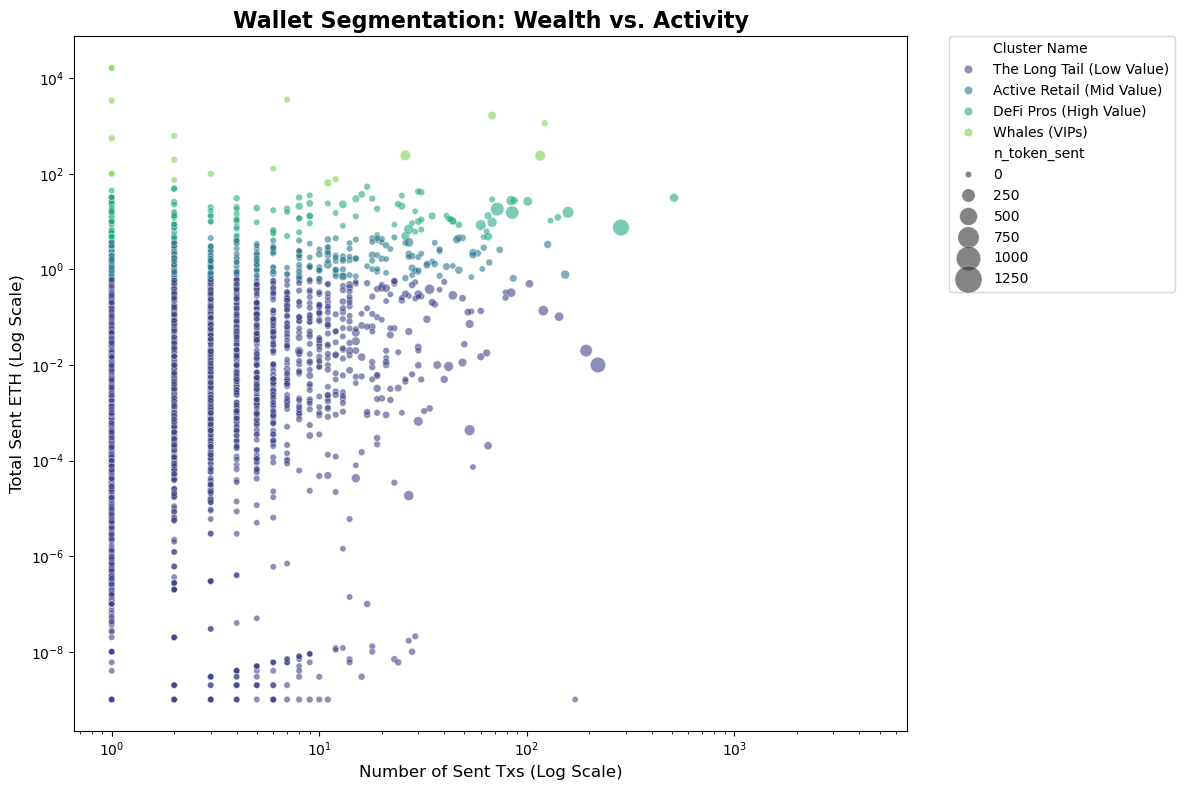

In [ ]:
cluster_names = {
    0: 'The Long Tail (Low Value)',
    1: 'DeFi Pros (High Value)',
    2: 'Whales (VIPs)',
    3: 'Active Retail (Mid Value)'
}
df['Cluster Name'] = df['cluster_id'].map(cluster_names)

# Sample again for plotting (Scatter plots hate 1M points)
plot_sample = df.sample(10000, random_state=42)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_sample,
    x='n_sent_tx',              # Activity
    y='total_sent_eth',         # Wealth
    hue='Cluster Name',         # Color by Persona
    size='n_token_sent',        # Size by DeFi Complexity
    sizes=(20, 400),
    alpha=0.6,
    palette='viridis'
)

plt.yscale('log')
plt.xscale('log')
plt.title('Wallet Segmentation: Wealth vs. Activity', fontsize=16, fontweight='bold')
plt.xlabel('Number of Sent Txs (Log Scale)', fontsize=12)
plt.ylabel('Total Sent ETH (Log Scale)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Move legend outside
plt.tight_layout()
plt.show()

In [14]:
# TRAIN & PREDICT

# 1. Initialize the Final Model
# Change n_clusters to 4, 5, or 6 based on your graph
k_best = 5 
kmeans_final = KMeans(n_clusters=k_best, random_state=42, n_init=10)

# 2. Fit on the scaled matrix (The Math)
print(f"Training KMeans with k={k_best}...")
kmeans_final.fit(X_scaled_df)

# 3. Assign labels back to the ORIGINAL DataFrame (The Context)
# This is where 'address' and 'total_sent_eth' meet the clusters
df['cluster_id'] = kmeans_final.labels_

print("Clustering Complete! 'cluster_id' column added to df.")

# --- STEP 7: INTERPRETATION (WHO ARE THEY?) ---

# We group by the NEW cluster ID and look at the OLD original columns
summary = df.groupby('cluster_id').agg({
    'address': 'count',                         # Size of the cluster
    'total_sent_eth': 'mean',                   # How rich are they?
    'n_sent_tx': 'mean',                        # How active?
    'avg_gas_price_gwei_sent': 'mean',          # Are they urgent (Bots)?
    'days_active_in_window': 'mean',            # Are they loyal?
    'fan_out_ratio': 'mean',                    # Are they spammers?
    'mule_score': 'mean',                       # Are they laundering money?
    'n_token_sent': 'mean'                      # Do they use DeFi?
}).round(4)

# Rename for clarity
summary = summary.rename(columns={'address': 'Wallet Count'})
print(summary)

Training KMeans with k=5...
Clustering Complete! 'cluster_id' column added to df.
            Wallet Count  total_sent_eth  n_sent_tx  avg_gas_price_gwei_sent  \
cluster_id                                                                     
0                1118130          0.0184     3.6975                   0.9229   
1                   7975         40.0732    31.6606                   1.3728   
2                   1358       4737.2302  1132.8535                   2.1025   
3                  22110          5.6550    15.1261                   1.3009   
4                  50427          1.1120    12.5868                   1.3567   

            days_active_in_window  fan_out_ratio  mule_score  n_token_sent  
cluster_id                                                                  
0                          2.5570         0.8477      0.2489        3.2652  
1                          9.3833         0.6013      0.6733       28.1788  
2                         13.4882         0.4691 

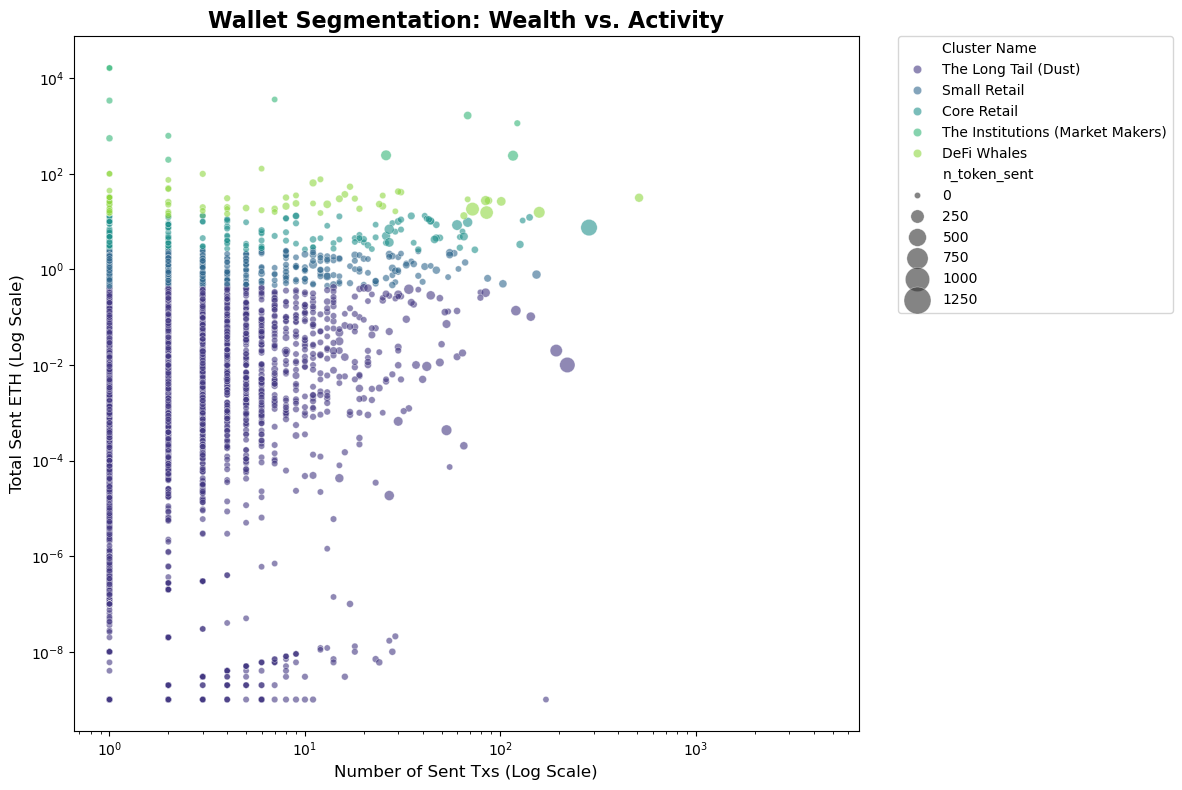

In [15]:
# Map the Cluster IDs to Names for the Legend
cluster_names = {
    0: 'The Long Tail (Dust)',
    1: 'DeFi Whales',
    2: 'The Institutions (Market Makers)',
    3: 'Core Retail',
    4: 'Small Retail'
}
df['Cluster Name'] = df['cluster_id'].map(cluster_names)

# Sample again for plotting (Scatter plots hate 1M points)
plot_sample = df.sample(10000, random_state=42)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_sample,
    x='n_sent_tx',              # Activity
    y='total_sent_eth',         # Wealth
    hue='Cluster Name',         # Color by Persona
    size='n_token_sent',        # Size by DeFi Complexity
    sizes=(20, 400),
    alpha=0.6,
    palette='viridis'
)

plt.yscale('log')
plt.xscale('log')
plt.title('Wallet Segmentation: Wealth vs. Activity', fontsize=16, fontweight='bold')
plt.xlabel('Number of Sent Txs (Log Scale)', fontsize=12)
plt.ylabel('Total Sent ETH (Log Scale)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Move legend outside
plt.tight_layout()
plt.show()

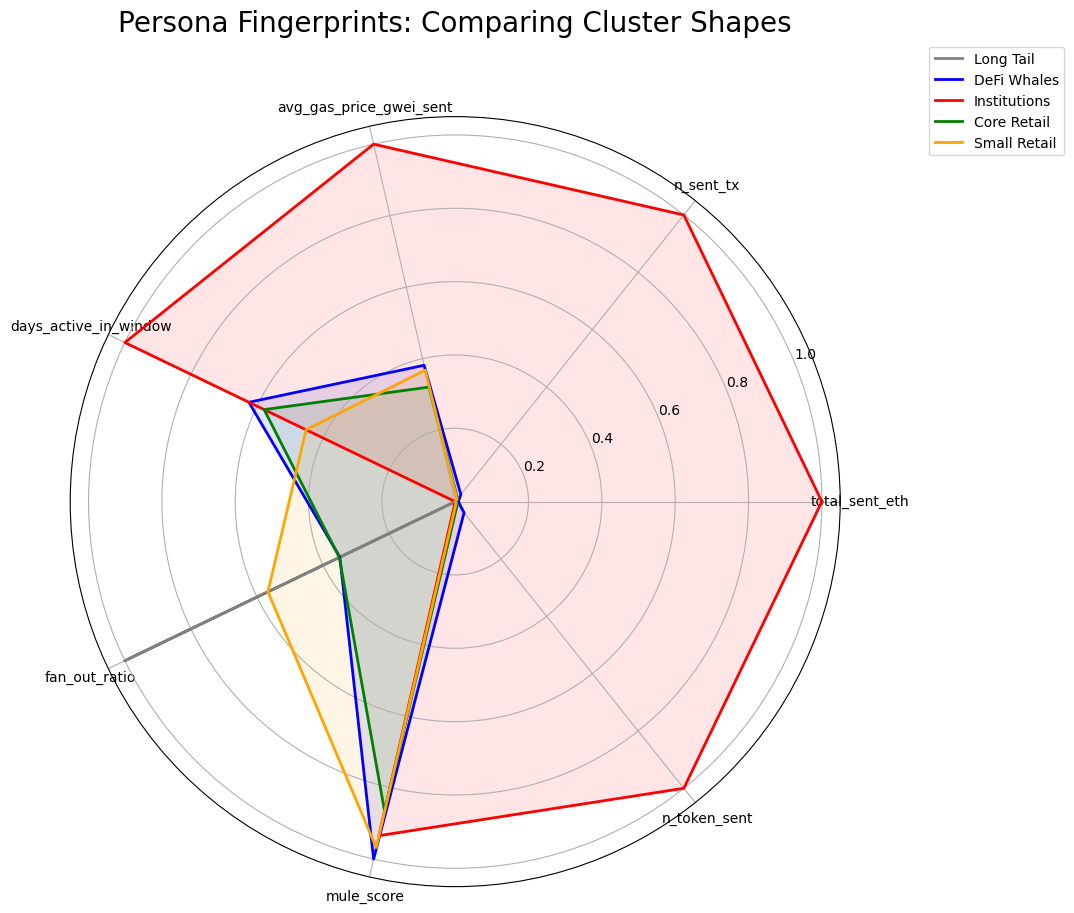

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Prepare Data for Radar Chart
# We take the summary table you just printed
radar_data = summary.drop(columns=['Wallet Count']).reset_index()

# Normalize columns to 0-1 scale so they fit on the same chart
scaler = MinMaxScaler()
radar_scaled = pd.DataFrame(scaler.fit_transform(radar_data.iloc[:, 1:]), columns=radar_data.columns[1:])
radar_scaled['cluster_id'] = radar_data['cluster_id']

# 2. Setup the Radar Plot
categories = list(radar_scaled.columns[:-1])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Close the circle

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 3. Draw one line per Cluster
colors = ['grey', 'blue', 'red', 'green', 'orange']
labels = ['Long Tail', 'DeFi Whales', 'Institutions', 'Core Retail', 'Small Retail']

for i in range(len(radar_scaled)):
    values = radar_scaled.loc[i].drop('cluster_id').values.flatten().tolist()
    values += values[:1] # Close the circle
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# Add Labels
plt.xticks(angles[:-1], categories, size=10)
plt.title("Persona Fingerprints: Comparing Cluster Shapes", size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()